In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['densenet-keras', 'aptos2019-blindness-detection']


# Resources:

https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter

# Imports

In [112]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

# Set random seed for reproducibility.
np.random.seed(2019)
tf.set_random_seed(2019)

# Target & ID Loading

In [113]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [114]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [115]:
train_df, val_df = train_test_split(train_df,test_size=0.30, random_state=42)

In [116]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(2563, 2)
(1099, 2)


# Image Loading & Pre-processing

In [117]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [118]:
# get the number of training images from the target\id dataset
N = train_df.shape[0]
# create an empty matrix for storing the images
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

# loop through the images from the images ids from the target\id dataset
# then grab the cooresponding image from disk, pre-process, and store in matrix in memory
for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 2563/2563 [05:50<00:00,  6.42it/s]


In [119]:
# do the same thing as the last cell but on the test\holdout set

N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:32<00:00, 20.85it/s]


In [120]:
# pre-processing the target (i.e. one-hot encoding the target)
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(2563, 224, 224, 3)
(2563, 5)
(1928, 224, 224, 3)


In [213]:
x_test[2]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [121]:
# Further target pre-processing

# Instead of predicting a single label, we will change our target to be a multilabel problem; 
# i.e., if the target is a certain class, then it encompasses all the classes before it. 
# E.g. encoding a class 4 retinopathy would usually be [0, 0, 0, 1], 
# but in our case we will predict [1, 1, 1, 1]. For more details, 
# please check out Lex's kernel.

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1265  272  697  138  191]
Multilabel version: [2563 1298 1026  329  191]


# Train & Validation Split

In [122]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.50, 
    random_state=2019
)

In [215]:
x_val[1]

array([[[4, 4, 6],
        [4, 4, 6],
        [4, 4, 6],
        ...,
        [4, 4, 6],
        [4, 4, 6],
        [4, 4, 7]],

       [[4, 4, 6],
        [4, 4, 6],
        [4, 4, 6],
        ...,
        [4, 4, 6],
        [4, 4, 6],
        [4, 4, 6]],

       [[4, 4, 6],
        [4, 4, 6],
        [4, 4, 6],
        ...,
        [4, 4, 6],
        [4, 4, 6],
        [4, 4, 6]],

       ...,

       [[4, 4, 6],
        [4, 4, 7],
        [4, 4, 7],
        ...,
        [4, 4, 6],
        [4, 4, 6],
        [4, 4, 7]],

       [[4, 4, 6],
        [4, 4, 6],
        [4, 4, 7],
        ...,
        [4, 4, 6],
        [4, 4, 7],
        [4, 4, 7]],

       [[4, 4, 6],
        [4, 4, 6],
        [4, 4, 7],
        ...,
        [4, 4, 6],
        [4, 4, 6],
        [4, 4, 6]]], dtype=uint8)

# Create Image Augmentation Generator

In [123]:
BATCH_SIZE = 13

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
val_datagen = ImageDataGenerator(rescale=1./255) 
# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

# Create Model

In [124]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [125]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.80))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00010509613402110064),
        metrics=['accuracy']
    )
    
    return model

In [126]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


# Train Model

In [127]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('main.h5')

        return

In [128]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', np.unique(train_df['diagnosis']), train_df['diagnosis'])
class_weight_dict = dict(enumerate(class_weights))

In [129]:
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [130]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[kappa_metrics]
)

Epoch 1/15
99/98 [==============================] - 92s 929ms/step - loss: 0.2490 - acc: 0.7388 - val_loss: 0.3117 - val_acc: 0.8382
val_kappa: 0.6852
Validation Kappa has improved. Saving model.
Epoch 2/15
99/98 [==============================] - 26s 265ms/step - loss: 0.1259 - acc: 0.8775 - val_loss: 0.1436 - val_acc: 0.9449
val_kappa: 0.8820
Validation Kappa has improved. Saving model.
Epoch 3/15
99/98 [==============================] - 26s 265ms/step - loss: 0.0983 - acc: 0.9071 - val_loss: 0.1333 - val_acc: 0.9474
val_kappa: 0.8650
Epoch 4/15
99/98 [==============================] - 26s 266ms/step - loss: 0.0867 - acc: 0.9158 - val_loss: 0.1229 - val_acc: 0.9490
val_kappa: 0.8857
Validation Kappa has improved. Saving model.
Epoch 5/15
99/98 [==============================] - 26s 266ms/step - loss: 0.0780 - acc: 0.9299 - val_loss: 0.1157 - val_acc: 0.9530
val_kappa: 0.8914
Validation Kappa has improved. Saving model.
Epoch 6/15
99/98 [==============================] - 26s 266ms/ste

# Training Plots

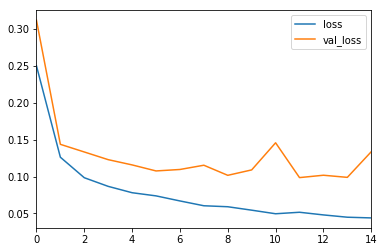

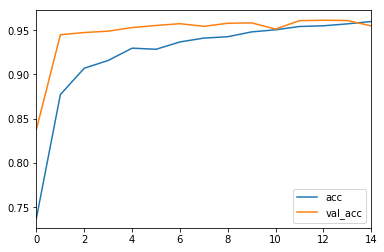

In [131]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [181]:
y_val_pred = model.predict(x_val)
y_val_pred

array([[9.9986464e-01, 9.9902821e-01, 9.9758434e-01, 9.9442208e-01,
        9.9065256e-01],
       [9.9994493e-01, 1.3092160e-04, 7.3164701e-05, 6.0319901e-05,
        1.0973215e-04],
       [9.9999988e-01, 0.0000000e+00, 0.0000000e+00, 1.4901161e-07,
        1.7881393e-07],
       ...,
       [9.9951971e-01, 9.9842584e-01, 8.0625021e-01, 1.4637709e-03,
        1.5530884e-03],
       [9.9951673e-01, 9.9978435e-01, 9.4811845e-01, 5.4663122e-03,
        6.7224503e-03],
       [9.9689716e-01, 9.9562204e-01, 9.1634822e-01, 5.7003614e-02,
        3.1764153e-02]], dtype=float32)

In [182]:
y_best = y_val_pred > 0.37757874193797547
y_best

array([[ True,  True,  True,  True,  True],
       [ True, False, False, False, False],
       [ True, False, False, False, False],
       ...,
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True, False, False]])

In [183]:
y_best  = y_best .astype(int).sum(axis=1) - 1

In [184]:
y_true = y_val.sum(axis=1) - 1

In [185]:
y_true[:20]

array([3, 0, 0, 3, 1, 0, 0, 0, 1, 3, 2, 0, 4, 0, 2, 2, 0, 3, 0, 0],
      dtype=uint64)

In [186]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_best, y_true))

Confusion Matrix
[[645  11   6   0   0]
 [  5  76  27   1   5]
 [  3  43 310  58  42]
 [  0   0   1   8   9]
 [  0   0   0   4  28]]


In [187]:
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best, y_true, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       No DR       0.99      0.97      0.98       662
        Mild       0.58      0.67      0.62       114
    Moderate       0.90      0.68      0.78       456
      Severe       0.11      0.44      0.18        18
Poliferative       0.33      0.88      0.48        32

    accuracy                           0.83      1282
   macro avg       0.58      0.73      0.61      1282
weighted avg       0.89      0.83      0.85      1282



In [188]:
cm = confusion_matrix(y_best, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("Specificity:", specificity)

Sensitivity (True Positive Rate or Recall): 0.9382716049382716
Specificity: 0.9832317073170732


In [189]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best, average=None)

recall = recall_score(y_true, y_best, average=None)

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)


Precision for each class:
[0.97432024 0.66666667 0.67982456 0.44444444 0.875     ]

Recall for each class:
[0.98774885 0.58461538 0.90116279 0.11267606 0.33333333]


In [190]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best, average='micro')

recall = recall_score(y_true, y_best, average='micro')

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)


Precision for each class:
0.8322932917316692

Recall for each class:
0.8322932917316692


In [200]:
misclassified=np.where(y_best!=y_true)
misclassified

(array([   0,    3,    4,    9,   12,   13,   17,   20,   24,   31,   33,
          36,   41,   44,   46,   58,   71,   75,   77,   83,   86,   88,
         103,  109,  116,  122,  129,  131,  137,  152,  158,  163,  170,
         173,  194,  199,  202,  208,  211,  212,  215,  217,  218,  287,
         288,  292,  294,  296,  313,  320,  329,  330,  342,  343,  344,
         346,  353,  366,  375,  378,  379,  382,  387,  390,  393,  408,
         412,  416,  428,  434,  437,  448,  450,  451,  475,  477,  479,
         481,  484,  485,  491,  493,  495,  518,  524,  525,  527,  530,
         537,  538,  560,  569,  576,  578,  586,  594,  599,  603,  604,
         608,  648,  652,  654,  665,  666,  673,  678,  679,  682,  685,
         687,  695,  699,  703,  704,  705,  716,  717,  727,  729,  732,
         733,  734,  747,  753,  754,  766,  767,  768,  771,  787,  795,
         810,  814,  828,  832,  837,  843,  846,  847,  850,  872,  879,
         895,  906,  907,  913,  915, 

In [208]:
print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best[15])

Total Misclassified Samples:  215
2 2


In [256]:
img = Image.open('/kaggle/input/aptos2019-blindness-detection/train_images/03747397839f.png')

# Resize the image
desired_size = (224, 224)
img = img.resize(desired_size)

# Convert the image to a numpy array
img_array = np.array(img)

# Ensure RGB format
if img_array.shape[2] == 4:  # If image has an alpha channel, remove it
    img_array = img_array[:, :, :3]

# Ensure uint8 data type
img_array = img_array.astype(np.uint8)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

# Thresholding and adjustment
threshold = 0.37757874193797547
y_test_thresholded = predictions > threshold
y_test_binary = y_test_thresholded.astype(int)
y_test_adjusted = y_test_binary.sum(axis=1) - 1

# Print the predicted class
print("Predicted class:", y_test_adjusted)
y_test_adjusted.dtype

Predicted class: [2]


dtype('int64')

In [239]:
img = Image.open('/kaggle/input/aptos2019-blindness-detection/train_images/001639a390f0.png')

# Resize the image
desired_size = (224, 224)
img = img.resize(desired_size)

# Convert the image to a numpy array
img_array = np.array(img)

# Ensure RGB format
if img_array.shape[2] == 4:  # If image has an alpha channel, remove it
    img_array = img_array[:, :, :3]

# Ensure uint8 data type
img_array = img_array.astype(np.uint8)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

# Thresholding and adjustment
threshold = 0.37757874193797547
y_test_thresholded = predictions > threshold
y_test_binary = y_test_thresholded.astype(int)
y_test_adjusted = y_test_binary.sum(axis=1) - 1

# Print the predicted class
print("Predicted class:", y_test_adjusted)
y_test_adjusted.dtype

Predicted class: [4]


dtype('int64')

In [259]:
img = Image.open('/kaggle/input/aptos2019-blindness-detection/train_images/01b3aed3ed4c.png')

# Resize the image
desired_size = (224, 224)
img = img.resize(desired_size)

# Convert the image to a numpy array
img_array = np.array(img)

# Ensure RGB format
if img_array.shape[2] == 4:  # If image has an alpha channel, remove it
    img_array = img_array[:, :, :3]

# Ensure uint8 data type
img_array = img_array.astype(np.uint8)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

# Thresholding and adjustment
threshold = 0.37757874193797547
y_test_thresholded = predictions > threshold
y_test_binary = y_test_thresholded.astype(int)
y_test_adjusted = y_test_binary.sum(axis=1) - 1

# Print the predicted class
print("Predicted class:", y_test_adjusted)
y_test_adjusted.dtype

Predicted class: [1]


dtype('int64')

In [255]:
img = Image.open('/kaggle/input/aptos2019-blindness-detection/train_images/03b373718013.png')

# Resize the image
desired_size = (224, 224)
img = img.resize(desired_size)

# Convert the image to a numpy array
img_array = np.array(img)

# Ensure RGB format
if img_array.shape[2] == 4:  # If image has an alpha channel, remove it
    img_array = img_array[:, :, :3]

# Ensure uint8 data type
img_array = img_array.astype(np.uint8)
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)

# Thresholding and adjustment
threshold = 0.37757874193797547
y_test_thresholded = predictions > threshold
y_test_binary = y_test_thresholded.astype(int)
y_test_adjusted = y_test_binary.sum(axis=1) - 1

# Print the predicted class
print("Predicted class:", y_test_adjusted)
y_test_adjusted.dtype

Predicted class: [0]


dtype('int64')

**Evaluate The Model**

In [237]:
directory_path = "C:/STUDY/Sem 6/SGP/model/"

# Create the directory if it does not exist
os.makedirs(directory_path, exist_ok=True)

# Save the model
model.save(directory_path + "dr.h5")